<a href="https://colab.research.google.com/github/lcjishi/Identify-Regenerative-Organizing-Cell-in-Frog-Tail-Skin/blob/main/Frog_and_tail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can frog grow its tail back?


## Data accession

Load data from the link directly or load it through Courseworks .zip file.

In [27]:
!wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip \
     -O /content/drive/MyDrive/stat5243/project1/arrayExpressUpload.zip

--2025-10-03 19:44:48--  https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94419121 (90M) [application/zip]
Saving to: ‘/content/drive/MyDrive/stat5243/project1/arrayExpressUpload.zip’

/content/drive/MyDr 100%[===================>]  90.04M  23.7MB/s    in 4.3s    

2025-10-03 19:44:53 (20.7 MB/s) - ‘/content/drive/MyDrive/stat5243/project1/arrayExpressUpload.zip’ saved [94419121/94419121]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import zipfile
import os

zip_file = "/content/drive/MyDrive/stat5243/project1/arrayExpressUpload.zip"
extract_dir = "/content/drive/MyDrive/stat5243/project1/Frogtail_files/"

os.makedirs(extract_dir, exist_ok=True) # create the extraction directory if it doesn't exist

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/stat5243/project1/Frogtail_files/


In [30]:
zip_file = extract_dir+"ArrayExpressV2.zip" # file is a nested zip, dezip again

with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
    zip_ref.extractall(extract_dir)

print(f"Files extracted to {extract_dir}")

Files extracted to /content/drive/MyDrive/stat5243/project1/Frogtail_files/


## Make an anndata matrix using scanpy or anndata

Usually single cell data is either directly stored in highdimensional files with .h5 extensions or in compressed count matrices with several tsv/csv/json logging the covariates information. Here is an example of how to compress and download this data into an anndata object that facilitates downstream single cell analysis.

- AnnData object for single cell data:  [Documentation](https://https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)
- Scanpy for single cell analysis: [Documentation](https://scanpy.readthedocs.io/en/stable/index.html)



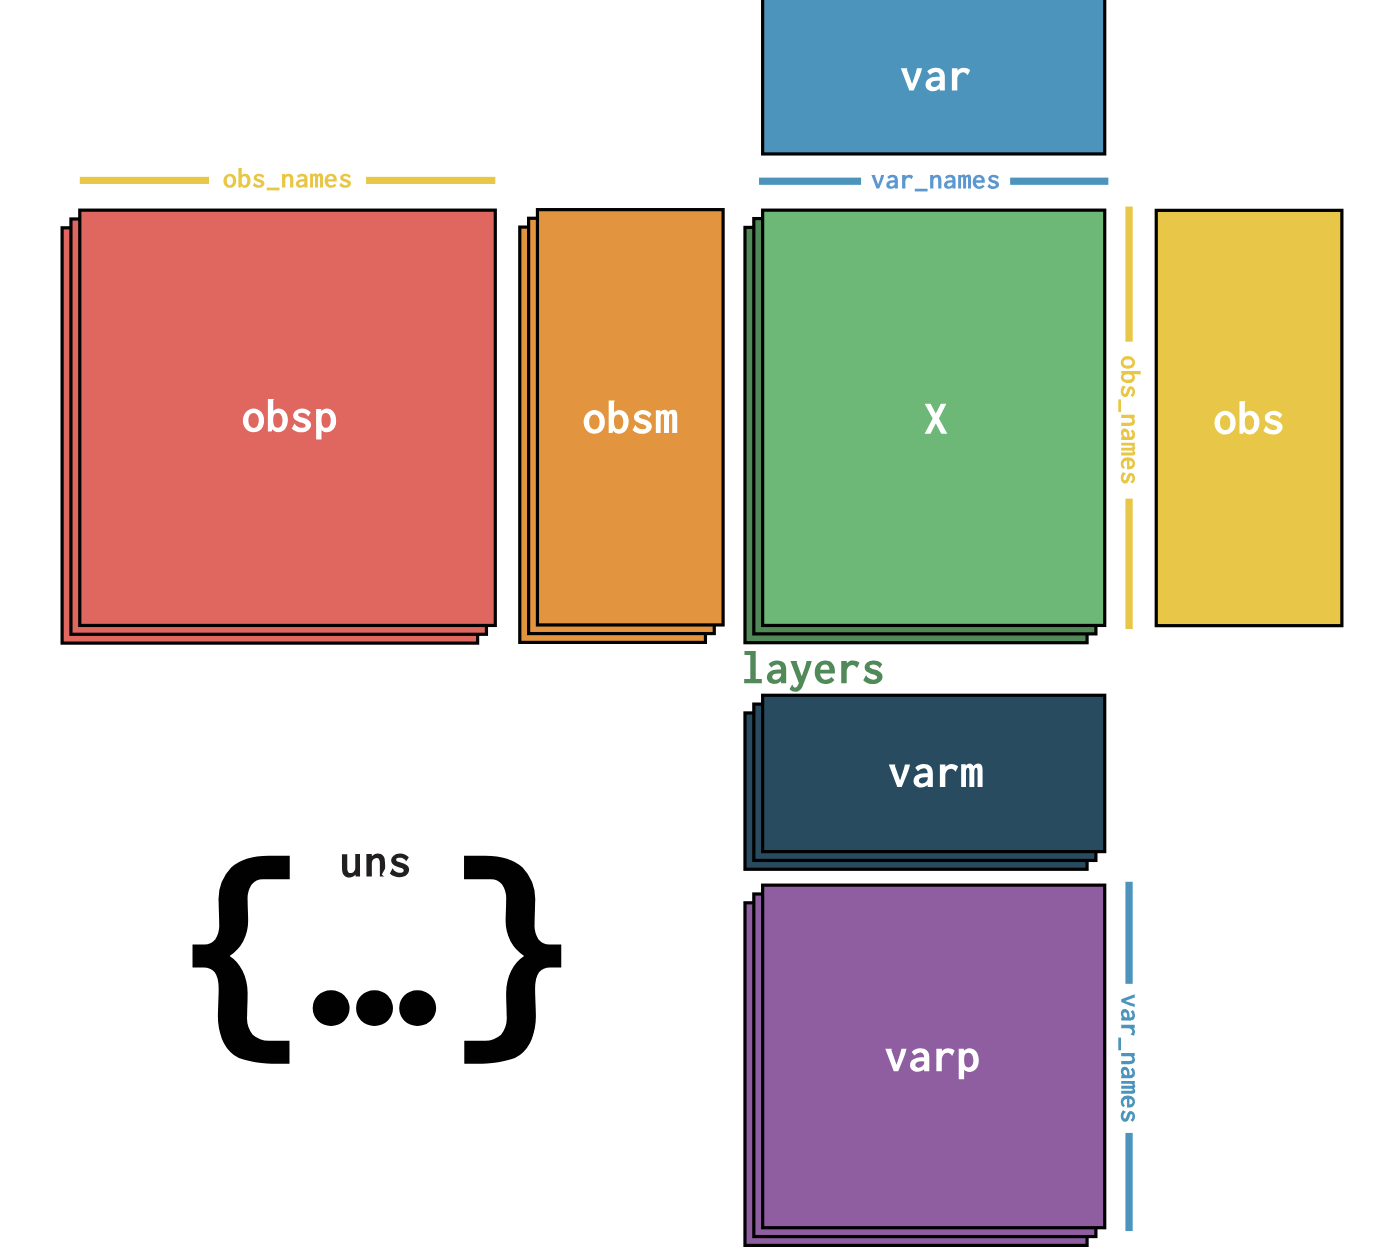

In [2]:
!pip install anndata
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.3 MB/s eta 0:00:00


In [3]:
!pip install python-igraph leidenalg
!pip install louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for louvain: filename=louvain-0.8.2-cp312-cp312-linux_x86_64.whl size=971849 sha256=6fb30911bca06932383cba394ef4c537b7fc59ff8032008c436579f952c3031f
  Stored in directory: /root/.cache/pip/wheels/40/de/2b/bb7ed19d84727f9f299f20cd34c42bba9c8bef7d83d2255c86
Successfully built louvain


In [4]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse
import matplotlib.pyplot as plt

In [ ]:
X = mmread(extract_dir+'ArrayExpress/countsMatrix.mtx') # compressed sparse matrix of gene expression
X = X.tocsr()
genes = pd.read_csv(extract_dir+'ArrayExpress/genes.csv', sep=' ', header=None) # col names of genes
cells = pd.read_csv(extract_dir+'ArrayExpress/cells.csv', sep=' ', header=None) # row names of cells
labels = pd.read_csv(extract_dir+'ArrayExpress/labels.csv')
meta = pd.read_csv(extract_dir+'ArrayExpress/meta.csv')


adata = ad.AnnData(X.T)

In [33]:
cells.columns = ['barcode_cells']
meta_aug = pd.merge(meta, labels, left_on='sample', right_on='Sample', how='left')

In [34]:
adata.var_names = genes[0]
adata.obs = pd.merge(cells, meta_aug, left_on='barcode_cells', right_on='cell')


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [35]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [36]:
adata.var

""
Xelaev18000001m.g
Xelaev18000003m.g
Xelaev18000004m.g
Xelaev18000005m.g
tm6sf2.1
...
loc101731491.S
loc101731436.S
Xetrov90022661m.S
loc398467.S


In [37]:
adata.X = adata.X.tocsr()

In [38]:
adata.write_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad')

## Load data

In [5]:
import anndata as ad

extract_dir = "/content/drive/MyDrive/stat5243/project1/Frogtail_files/"
adata = ad.read_h5ad(extract_dir + "cleaned_processed_frogtail.h5ad")


/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


In [6]:
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [7]:
adata.obs

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13194,TTCTTAGAGTACCGGA.1,TTCTTAGAGTACCGGA.1,SIGAB10,st40,3,Erythrocyte 4,-5.879582,0.924197,G2M,SIGAB10,SLX-15739,ST40_3,4
13195,TTGACTTAGAGTAAGG.1,TTGACTTAGAGTAAGG.1,SIGAB10,st40,3,Goblet cell,1.252149,-8.870151,G1,SIGAB10,SLX-15739,ST40_3,4
13196,TTGCGTCTCAAGAAGT.1,TTGCGTCTCAAGAAGT.1,SIGAB10,st40,3,Goblet cell,0.693335,-9.168521,G1,SIGAB10,SLX-15739,ST40_3,4
13197,TTGTAGGCAGTACACT.1,TTGTAGGCAGTACACT.1,SIGAB10,st40,3,Erythrocyte 1,-4.087618,4.145738,G1,SIGAB10,SLX-15739,ST40_3,4


In [9]:
adata

AnnData object with n_obs × n_vars = 13199 × 31535
    obs: 'barcode_cells', 'cell', 'sample', 'DevelopmentalStage', 'DaysPostAmputation', 'cluster', 'X', 'Y', 'CellCyclePhase', 'Sample', 'Lane', 'Condition', 'batch'

In [8]:
adata.X.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [48]:
adata.obs

,barcode_cells,cell,sample,DevelopmentalStage,DaysPostAmputation,cluster,X,Y,CellCyclePhase,Sample,Lane,Condition,batch
0,AAACCTGAGCTAGTTC.1,AAACCTGAGCTAGTTC.1,SIGAB5,st40,3,Erythrocyte 4,-6.395430,0.832323,G2M,SIGAB5,SLX-15583,ST40_3,3
1,AAACCTGGTGGGTCAA.1,AAACCTGGTGGGTCAA.1,SIGAB5,st40,3,Myeloid 1,-2.428271,13.826715,G1,SIGAB5,SLX-15583,ST40_3,3
2,AAACCTGGTTTGTTGG.1,AAACCTGGTTTGTTGG.1,SIGAB5,st40,3,Beta ionocyte,-1.398049,-14.653897,G1,SIGAB5,SLX-15583,ST40_3,3
3,AAACGGGGTCGGCATC.1,AAACGGGGTCGGCATC.1,SIGAB5,st40,3,Erythrocyte 4,-5.863765,0.489598,G2M,SIGAB5,SLX-15583,ST40_3,3
4,AAACGGGTCCTACAGA.1,AAACGGGTCCTACAGA.1,SIGAB5,st40,3,Goblet cell,2.106444,-6.594430,G1,SIGAB5,SLX-15583,ST40_3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13194,TTCTTAGAGTACCGGA.1,TTCTTAGAGTACCGGA.1,SIGAB10,st40,3,Erythrocyte 4,-5.879582,0.924197,G2M,SIGAB10,SLX-15739,ST40_3,4
13195,TTGACTTAGAGTAAGG.1,TTGACTTAGAGTAAGG.1,SIGAB10,st40,3,Goblet cell,1.252149,-8.870151,G1,SIGAB10,SLX-15739,ST40_3,4
13196,TTGCGTCTCAAGAAGT.1,TTGCGTCTCAAGAAGT.1,SIGAB10,st40,3,Goblet cell,0.693335,-9.168521,G1,SIGAB10,SLX-15739,ST40_3,4
13197,TTGTAGGCAGTACACT.1,TTGTAGGCAGTACACT.1,SIGAB10,st40,3,Erythrocyte 1,-4.087618,4.145738,G1,SIGAB10,SLX-15739,ST40_3,4


## Processing data

In [8]:
adata.layers["counts"] = adata.X.copy()


In [9]:
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [10]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.highly_variable_genes(adata, n_top_genes=2300)

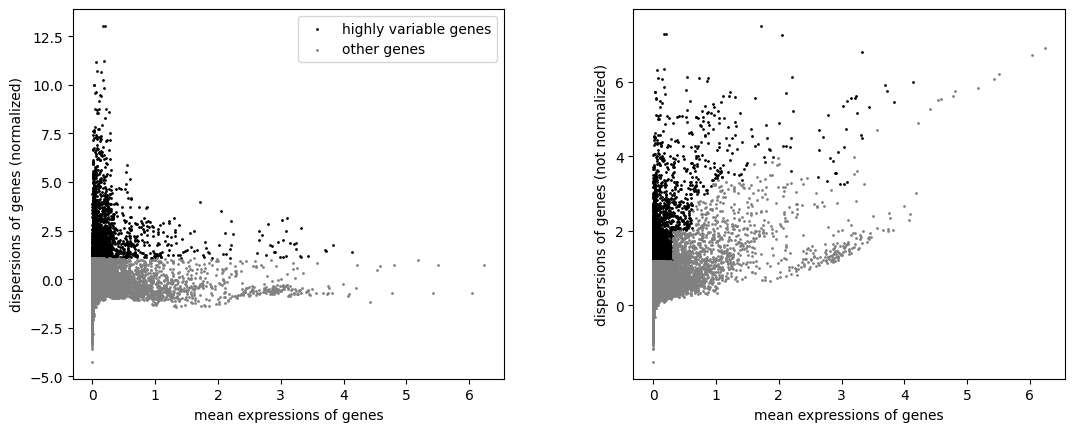

In [11]:
sc.pl.highly_variable_genes(adata)

## Clustering

In [12]:
# using HVGs
if "highly_variable" in adata.var:
    adata = adata[:, adata.var["highly_variable"]].copy()

# PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

# build kNN graph on PCA
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)

/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [13]:
# UMAP to visualize clusters
sc.tl.umap(adata)

In [14]:
# clustering PCA+Louvain & PCA+Leiden
sc.tl.louvain(adata, resolution=1.0)
sc.tl.leiden(adata,  resolution=1.0)

/tmp/ipython-input-3510676295.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,  resolution=1.0)


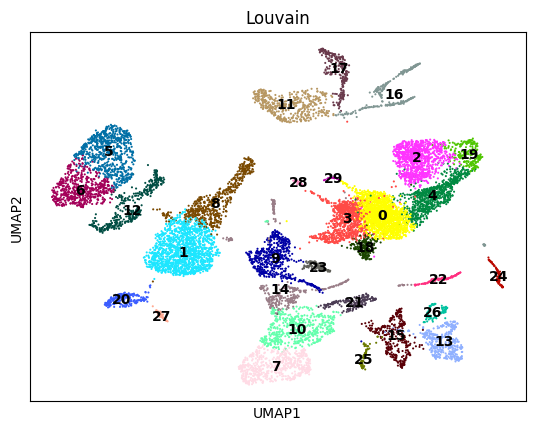

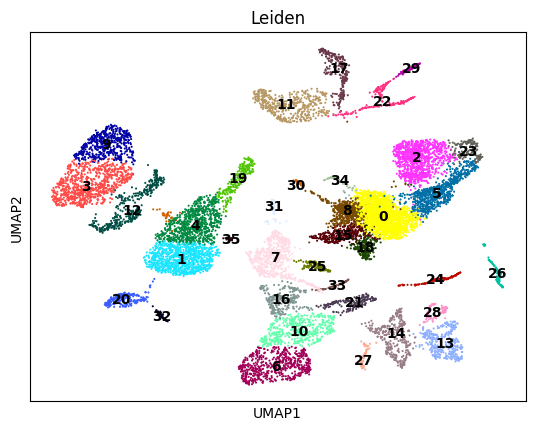

In [15]:
# UMAP visualizations
sc.pl.umap(adata, color=["louvain"], legend_loc="on data", title="Louvain")
sc.pl.umap(adata, color=["leiden"],  legend_loc="on data", title="Leiden")

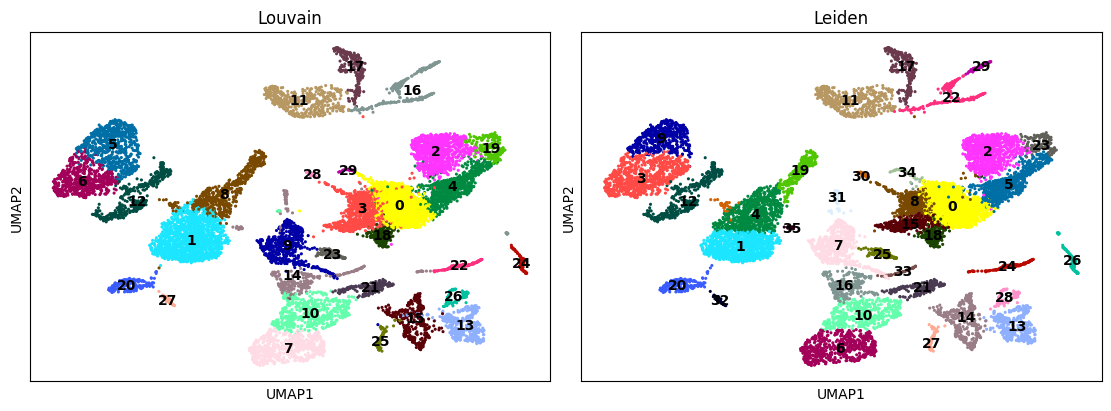

In [36]:
# make it as one figure for report
fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
sc.pl.umap(adata, color="louvain", ax=axes[0], title="Louvain",
           legend_loc="on data", size=20, show=False,)
sc.pl.umap(adata, color="leiden", ax=axes[1], title="Leiden",
    legend_loc="on data", size=20, show=False,)
plt.show()

### Metrics
#### Silhouette Score

In [17]:
def pairwise_euclidean(X: np.ndarray):
    """Compute full pairwise Euclidean distances"""
    sq = np.sum(X * X, axis=1, keepdims=True) # (n,1)
    D2 = sq + sq.T - 2.0 * (X @ X.T) # squared distances
    np.maximum(D2, 0.0, out=D2)
    D = np.sqrt(D2, out=D2)
    np.fill_diagonal(D, 0.0)
    return D

def silhouettes_piecewise(X: np.ndarray, labels):
    """
    a(i) = mean distance to same-cluster points (excl. i)
    b(i) = min over other clusters of mean distance to that cluster
    s(i) = piecewise (b-a)/max(a,b) from your slide
    Returns: s, a, b  (all shape (n,))
    """
    labels = np.asarray(labels)
    n = X.shape[0]
    D = pairwise_euclidean(X)

    # group indices by cluster
    clusters = {}
    for i, lab in enumerate(labels):
        clusters.setdefault(lab, []).append(i)
    clusters = {lab: np.asarray(idxs, dtype=int) for lab, idxs in clusters.items()}

    a = np.zeros(n, dtype=float)
    b = np.zeros(n, dtype=float)

    # a(i): intra-cluster mean distance excluding self
    for lab, idxs in clusters.items():
        k = len(idxs)
        if k == 1:
            a[idxs] = 0.0
        else:
            intra = D[np.ix_(idxs, idxs)]
            a[idxs] = intra.sum(axis=1) / (k - 1)

    # b(i): min mean distance to any other cluster
    for i in range(n):
        lab_i = labels[i]
        means = []
        for lab_j, idxs_j in clusters.items():
            if lab_j == lab_i:
                continue
            means.append(D[i, idxs_j].mean())
        b[i] = min(means) if means else 0.0 # single-cluster

    # piecewise silhouette
    s = np.zeros(n, dtype=float)
    m1 = (a < b) & (b > 0)
    s[m1] = 1.0 - (a[m1] / b[m1])
    m2 = (a > b) & (a > 0)
    s[m2] = (b[m2] / a[m2]) - 1.0

    return s, a, b

In [18]:
# use PCA embedding (first 30 PCs)
X_pca = adata.obsm["X_pca"][:, :30]
lou = adata.obs["louvain"].astype(str).values
lei = adata.obs["leiden"].astype(str).values

In [19]:
# silhouettes
s_lou, a_lou, b_lou = silhouettes_piecewise(X_pca, lou)
s_lei, a_lei, b_lei = silhouettes_piecewise(X_pca, lei)

adata.obs["sil_louvain_def"] = s_lou
adata.obs["sil_leiden_def"]  = s_lei

print("Mean Silhouette Louvain:", s_lou.mean())
print("Mean Silhouette Leiden:", s_lei.mean())

Mean Silhouette Louvain: 0.24830635588602917
Mean Silhouette Leiden: 0.28245447037442845


#### Rand Index and ARI

In [20]:
def contingency(u: np.ndarray, v: np.ndarray):
    """Contingency table N_{ij}."""
    df = pd.crosstab(pd.Series(u, dtype="category"), pd.Series(v, dtype="category"))
    return df.values.astype(np.int64)

def comb2(x):
    return x * (x - 1) / 2.0

def rand_index(u, v) -> float:
    """(TP+TN)/C(n,2) from contingency."""
    u = np.asarray(u)
    v = np.asarray(v)
    n = u.size
    if n < 2:
        return 1.0
    N = contingency(u, v)
    nij2 = comb2(N).sum()
    ai = N.sum(axis=1)
    bj = N.sum(axis=0)
    ai2 = comb2(ai).sum()
    bj2 = comb2(bj).sum()
    total_pairs = comb2(n)
    TP = nij2
    FP = ai2 - TP
    FN = bj2 - TP
    TN = total_pairs - TP - FP - FN
    return (TP + TN) / total_pairs

def adjusted_ri(u, v) -> float:
    """Hubert & Arabie ARI from contingency."""
    u = np.asarray(u)
    v = np.asarray(v)
    n = u.size
    if n < 2:
        return 1.0
    N = contingency(u, v)
    nij2 = comb2(N).sum()
    ai = N.sum(axis=1)
    bj = N.sum(axis=0)
    ai2 = comb2(ai).sum()
    bj2 = comb2(bj).sum()
    total_pairs = comb2(n)
    expected = (ai2 * bj2) / total_pairs
    max_idx = 0.5 * (ai2 + bj2)
    denom = max_idx - expected
    if denom == 0:
        return 0.0
    return (nij2 - expected) / denom

In [21]:
ri  = rand_index(lou, lei)
ari = adjusted_ri(lou, lei)

print("Rand Index:", float(ri))
print("Adjusted Rand Index:", float(ari))


Rand Index: 0.9784248488703258
Adjusted Rand Index: 0.8019367588047609


#### Normalized Mutual Information

In [22]:
def normalized_mutual_information(u, v, eps=1e-12):
    """
    NMI = I(U;V) / sqrt(H(U) H(V)), natural logs.
    """
    u = np.asarray(u)
    v = np.asarray(v)
    n = u.size
    N = contingency(u, v).astype(float)
    a = N.sum(axis=1, keepdims=True)  # (r,1)
    b = N.sum(axis=0, keepdims=True)  # (1,c)
    # probabilities
    P = N / n
    Pu = a / n
    Pv = b / n

    # mutual information
    num = (N * n)  # n_ij * n
    den = (a @ b)  # a_i * b_j
    with np.errstate(divide='ignore', invalid='ignore'):
        term = P * np.log((num + eps) / (den + eps))
    I = np.nansum(term)

    # entropies
    Hu = -np.nansum(Pu * np.log(Pu + eps))
    Hv = -np.nansum(Pv * np.log(Pv + eps))
    if Hu <= 0 or Hv <= 0:
        return 0.0
    return float(I / np.sqrt(Hu * Hv))

In [23]:
nmi = normalized_mutual_information(lou, lei)
print(nmi)

0.9038236627177362


## Marker Selection & Gene Analysis

In [24]:
# Wilcoxon test
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon",
    key_added="rank_wilcoxon", use_raw=False)

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

In [25]:
# t-test
sc.tl.rank_genes_groups(adata, groupby="leiden", method="t-test_overestim_var",
    key_added="rank_ttestov", use_raw=False)

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

In [26]:
def _rank_markers(D, group_key, prefix):
    sc.tl.rank_genes_groups(D, groupby=group_key, method="wilcoxon",
                            key_added=f"{prefix}_wilc", use_raw=False)
    sc.tl.rank_genes_groups(D, groupby=group_key, method="t-test_overestim_var",
                            key_added=f"{prefix}_tov",  use_raw=False)
    def tidy(key):
        r = D.uns[key]
        dfn = pd.DataFrame(r["names"]).stack().reset_index().rename(columns={"level_0":"rank0","level_1":"cluster",0:"gene"})
        dfs = pd.DataFrame(r.get("scores")).stack().reset_index().rename(columns={"level_0":"rank0","level_1":"cluster",0:"score"})
        dfp = pd.DataFrame(r.get("pvals")).stack().reset_index().rename(columns={"level_0":"rank0","level_1":"cluster",0:"pval"})
        dfl = pd.DataFrame(r.get("logfoldchanges")).stack().reset_index().rename(columns={"level_0":"rank0","level_1":"cluster",0:"logFC"})
        out = dfn.merge(dfs, on=["rank0","cluster"], how="left").merge(dfp, on=["rank0","cluster"], how="left").merge(dfl, on=["rank0","cluster"], how="left")
        out["rank"] = out["rank0"] + 1
        return out[["cluster","rank","gene","score","pval","logFC"]].sort_values(["cluster","rank"])
    return tidy(f"{prefix}_wilc"), tidy(f"{prefix}_tov")

def _topk_overlap(dfA, dfB, k=50):
    A = dfA[dfA["rank"]<=k]; B = dfB[dfB["rank"]<=k]
    clus = sorted(set(A["cluster"]).intersection(B["cluster"]))
    rows=[]
    for c in clus:
        SA = set(A.loc[A.cluster==c,"gene"])
        SB = set(B.loc[B.cluster==c,"gene"])
        rows.append({"cluster": c, "overlap": len(SA & SB), "A_topk": len(SA), "B_topk": len(SB)})
    return pd.DataFrame(rows).sort_values("cluster")

In [27]:
# results into DataFrame, later can be use to compare
top_k = 50

df_wilcoxon, df_ttestov = _rank_markers(adata, group_key="leiden", prefix="rank")

top_k = 50
df_wilcoxon_top = df_wilcoxon[df_wilcoxon["rank"] <= top_k].copy()
df_ttestov_top  = df_ttestov [df_ttestov ["rank"] <= top_k].copy()

# compare overlaps
overlap_w_v_t = _topk_overlap(df_wilcoxon_top, df_ttestov_top, k=top_k)
print(overlap_w_v_t)

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

   cluster  overlap  A_topk  B_topk
0        0       34      50      50
1        1       45      50      50
2       10       46      50      50
3       11       47      50      50
4       12       48      50      50
5       13       50      50      50
6       14       48      50      50
7       15       42      50      50
8       16       36      50      50
9       17       48      50      50
10      18       39      50      50
11      19       45      50      50
12       2       37      50      50
13      20       48      50      50
14      21       45      50      50
15      22       43      50      50
16      23       36      50      50
17      24       49      50      50
18      25       47      50      50
19      26       43      50      50
20      27       47      50      50
21      28       47      50      50
22      29       49      50      50
23       3       48      50      50
24      30       45      50      50
25      31       47      50      50
26      32       44      50 

#### Compare Wilcoxon and t-test markers

In [28]:
# compare methods per cluster
# for overals on top-k
method_compare = _topk_overlap(df_wilcoxon, df_ttestov, k=top_k)  # returns: cluster, overlap, A_topk, B_topk
print("\nWilcoxon vs TTest-OV overlap (top_k per cluster):")
print(method_compare.sort_values("cluster"))


Wilcoxon vs TTest-OV overlap (top_k per cluster):
   cluster  overlap  A_topk  B_topk
0        0       34      50      50
1        1       45      50      50
2       10       46      50      50
3       11       47      50      50
4       12       48      50      50
5       13       50      50      50
6       14       48      50      50
7       15       42      50      50
8       16       36      50      50
9       17       48      50      50
10      18       39      50      50
11      19       45      50      50
12       2       37      50      50
13      20       48      50      50
14      21       45      50      50
15      22       43      50      50
16      23       36      50      50
17      24       49      50      50
18      25       47      50      50
19      26       43      50      50
20      27       47      50      50
21      28       47      50      50
22      29       49      50      50
23       3       48      50      50
24      30       45      50      50
25      31   

#### Compare gene set to Table S3

In [29]:
table3_path = "/content/drive/MyDrive/stat5243/project1/Frogtail_files/aav9996_tables3.xlsx"

In [30]:
# make a csv of all genes in file
def clean_series(s: pd.Series) -> pd.Series:
    out = (s.astype(str).str.strip()
             .replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "NAN": pd.NA})
             .dropna())
    return out.str.upper()

xls = pd.ExcelFile(table3_path)
per_sheet = {}
combined = set()

for sh in xls.sheet_names:
    df = pd.read_excel(table3_path, sheet_name=sh, header=None, usecols=[0])
    ser = clean_series(df.iloc[:, 0])
    per_sheet[sh] = ser
    combined.update(ser.tolist())

combined_df = pd.DataFrame(sorted(combined), columns=["gene"])
print(combined_df.head())

       gene
0  ADAMTS18
1    ANLN.L
2    ANLN.S
3  ANP32E.L
4  ANP32E.S


In [31]:
# build target gene sets
S3_all = set(combined_df["gene"])
S3_by_sheet = {sh: set(per_sheet[sh]) for sh in per_sheet}

def compare_markers_to_set(df_markers: pd.DataFrame, target_genes: set, top_k: int = 50, label: str = "") -> pd.DataFrame:
    """Compare per cluster overlap against a gene set."""
    d = df_markers[df_markers["rank"] <= top_k].copy()
    # normalize to uppercase for robust matching
    d["GENE_UPPER"] = d["gene"].astype(str).str.upper()
    rows = []
    for c, sub in d.groupby("cluster"):
        G = set(sub["GENE_UPPER"])
        inter = G & target_genes
        rows.append({"method": label,
            "cluster": c,
            "top_k": len(G),
            "s3_size": len(target_genes),
            "overlap": len(inter),
            "overlap_genes": ", ".join(sorted(inter))})
    return pd.DataFrame(rows).sort_values(["method","cluster"])

# compare with table s3
top_k = 50
cmp_wilc_all = compare_markers_to_set(df_wilcoxon, S3_all, top_k=top_k, label="wilcoxon")
cmp_tov_all  = compare_markers_to_set(df_ttestov,  S3_all, top_k=top_k, label="t-test_overestim_var")
cmp_all = pd.concat([cmp_wilc_all, cmp_tov_all], axis=0)
print("\nOverlap with Table S3 (combined across sheets):")
print(cmp_all)



Overlap with Table S3 (combined across sheets):
                  method cluster  top_k  s3_size  overlap  \
0               wilcoxon       0     50      343        0   
1               wilcoxon       1     50      343        0   
2               wilcoxon      10     50      343        0   
3               wilcoxon      11     50      343        0   
4               wilcoxon      12     50      343        0   
..                   ...     ...    ...      ...      ...   
31  t-test_overestim_var       5     50      343        4   
32  t-test_overestim_var       6     50      343        0   
33  t-test_overestim_var       7     50      343        0   
34  t-test_overestim_var       8     50      343        0   
35  t-test_overestim_var       9     50      343        0   

                       overlap_genes  
0                                     
1                                     
2                                     
3                                     
4                      

Annotate clusters using both methods

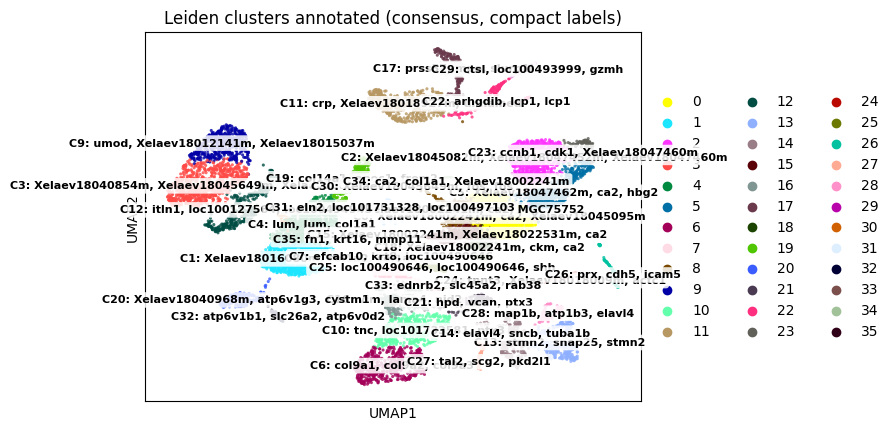

                                                     label
cluster                                                   
0                C0: Xelaev18002241m, ca2, Xelaev18045095m
1                      C1: Xelaev18016080m, col1a2, col1a1
2        C2: Xelaev18045082m, Xelaev18047452m, Xelaev18...
3        C3: Xelaev18040854m, Xelaev18045649m, Xelaev18...
4                                     C4: lum, lum, col1a1
5                           C5: Xelaev18047462m, ca2, hbg2
6                               C6: col9a1, col9a2, col9a3
7                          C7: efcab10, krt8, loc100490646
8                       C8: Xelaev18002241m, ca2, MGC75752
9               C9: umod, Xelaev18012141m, Xelaev18015037m
10                            C10: tnc, loc101733581, ptx3
11                      C11: crp, Xelaev18018927m, unnamed
12                  C12: itln1, loc100127564, loc100494945
13                               C13: stmn2, snap25, stmn2
14                               C14: elavl4, sncb, tuba

In [32]:
TOP_K = 50
N_LABEL_GENES = 3

Wk = df_wilcoxon[df_wilcoxon["rank"]<=TOP_K].rename(columns={"rank":"rank_w"})[["cluster","gene","rank_w"]]
Tk = df_ttestov [df_ttestov ["rank"]<=TOP_K].rename(columns={"rank":"rank_t"})[["cluster","gene","rank_t"]]

clusters = sorted(adata.obs["leiden"].astype(str).unique(), key=lambda x: (len(x), x))
label_map = {}

def _short(s):
    # trim long gene ids like "geneX.something.L" -> "geneX"
    return str(s).split(".")[0]

for c in clusters:
    U = pd.merge(Wk[Wk.cluster==c], Tk[Tk.cluster==c], on=["cluster","gene"], how="outer")
    if U.empty:
        label_map[c] = f"C{c}"
        continue
    U["rank_w"] = U["rank_w"].fillna(TOP_K+1)
    U["rank_t"] = U["rank_t"].fillna(TOP_K+1)
    U["avg_rank"] = U[["rank_w","rank_t"]].mean(axis=1)

    inter = U[(U["rank_w"]<=TOP_K) & (U["rank_t"]<=TOP_K)].sort_values("avg_rank").head(N_LABEL_GENES)
    if len(inter) < N_LABEL_GENES:
        need = N_LABEL_GENES - len(inter)
        pad = U.sort_values("avg_rank").loc[~U["gene"].isin(inter["gene"])].head(need)
        inter = pd.concat([inter, pad], axis=0, ignore_index=True)

    genes = [ _short(g) for g in inter["gene"].tolist() ]
    label_map[c] = f"C{c}: " + ", ".join(genes)

# plot points and add ONE centroid label per cluster ---
fig = sc.pl.umap(
    adata, color="leiden", legend_loc="right margin",
    size=20, alpha=0.8, return_fig=True  # return the matplotlib figure
)

ax = fig.axes[0]
coords = adata.obsm["X_umap"]
cl = adata.obs["leiden"].astype(str).values

# centroid per cluster (use median for robustness)
for i, c in enumerate(clusters):
    idx = (cl == c)
    if not np.any(idx):
        continue
    xy = np.median(coords[idx], axis=0)

    # small radial offset to reduce collisions between neighboring centroids
    angle = 2*np.pi * (i / max(1, len(clusters)))
    r = 0.1
    x_off = xy[0] + r*np.cos(angle)
    y_off = xy[1] + r*np.sin(angle)

    ax.text(
        x_off, y_off, label_map[c],
        ha="center", va="center", fontsize=8, weight="bold",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.85, ec="none"),
        zorder=10
    )

ax.set_title("Leiden clusters annotated (consensus, compact labels)")
plt.show()

print(pd.Series(label_map, name="label").rename_axis("cluster").to_frame())


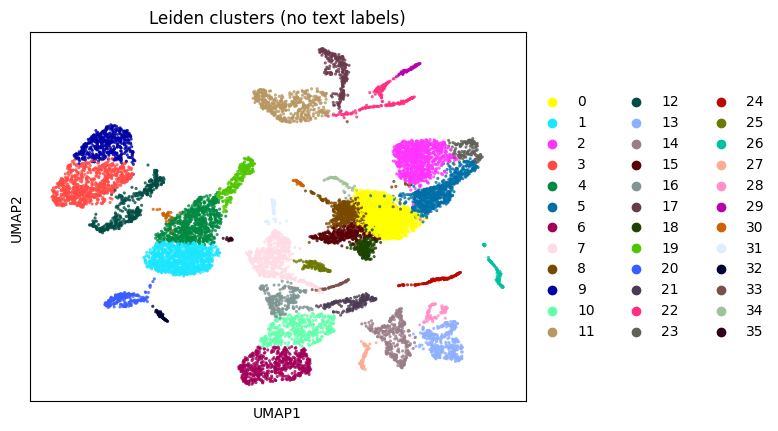

                                                     label
cluster                                                   
0                C0: Xelaev18002241m, ca2, Xelaev18045095m
1                      C1: Xelaev18016080m, col1a2, col1a1
2        C2: Xelaev18045082m, Xelaev18047452m, Xelaev18...
3        C3: Xelaev18040854m, Xelaev18045649m, Xelaev18...
4                                     C4: lum, lum, col1a1
5                           C5: Xelaev18047462m, ca2, hbg2
6                               C6: col9a1, col9a2, col9a3
7                          C7: efcab10, krt8, loc100490646
8                       C8: Xelaev18002241m, ca2, MGC75752
9               C9: umod, Xelaev18012141m, Xelaev18015037m
10                            C10: tnc, loc101733581, ptx3
11                      C11: crp, Xelaev18018927m, unnamed
12                  C12: itln1, loc100127564, loc100494945
13                               C13: stmn2, snap25, stmn2
14                               C14: elavl4, sncb, tuba

In [33]:
TOP_K = 50
N_LABEL_GENES = 3

Wk = df_wilcoxon[df_wilcoxon["rank"]<=TOP_K].rename(columns={"rank":"rank_w"})[["cluster","gene","rank_w"]]
Tk = df_ttestov [df_ttestov ["rank"]<=TOP_K].rename(columns={"rank":"rank_t"})[["cluster","gene","rank_t"]]

clusters = sorted(adata.obs["leiden"].astype(str).unique(), key=lambda x: (len(x), x))
label_map = {}

def _short(s):
    # trim long gene ids like "geneX.something.L" -> "geneX"
    return str(s).split(".")[0]

for c in clusters:
    U = pd.merge(Wk[Wk.cluster==c], Tk[Tk.cluster==c], on=["cluster","gene"], how="outer")
    if U.empty:
        label_map[c] = f"C{c}"
        continue
    U["rank_w"] = U["rank_w"].fillna(TOP_K+1)
    U["rank_t"] = U["rank_t"].fillna(TOP_K+1)
    U["avg_rank"] = U[["rank_w","rank_t"]].mean(axis=1)

    inter = U[(U["rank_w"]<=TOP_K) & (U["rank_t"]<=TOP_K)].sort_values("avg_rank").head(N_LABEL_GENES)
    if len(inter) < N_LABEL_GENES:
        need = N_LABEL_GENES - len(inter)
        pad = U.sort_values("avg_rank").loc[~U["gene"].isin(inter["gene"])].head(need)
        inter = pd.concat([inter, pad], axis=0, ignore_index=True)

    genes = [_short(g) for g in inter["gene"].tolist()]
    label_map[c] = f"C{c}: " + ", ".join(genes)

# UMAP: color by cluster only
fig = sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="right margin",
    size=20,
    alpha=0.8,
    return_fig=True
)
fig.axes[0].set_title("Leiden clusters (no text labels)")
plt.show()

# label table
label_df = pd.Series(label_map, name="label").rename_axis("cluster").to_frame()
print(label_df)


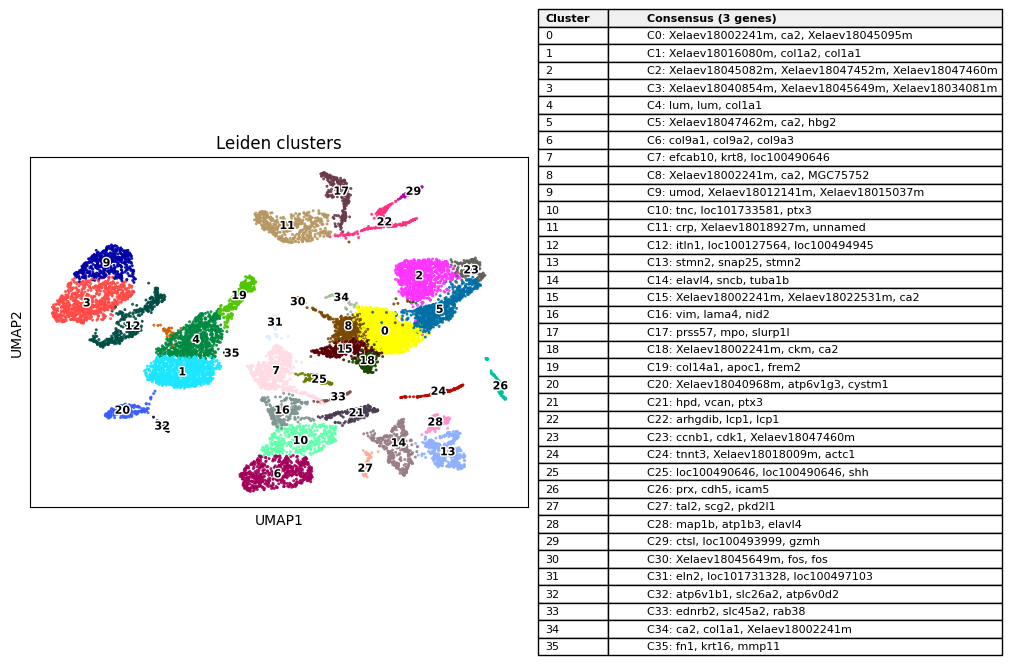

In [44]:
# used chatgpt here to make the results (umap + table) above combined to one figure
# assume label_map already built -> make a tidy table
label_df = (
    pd.Series(label_map, name="label").rename_axis("cluster").to_frame().reset_index()
    .assign(cluster=lambda d: d["cluster"].astype(int))
    .sort_values("cluster")
    .assign(cluster=lambda d: d["cluster"].astype(str))
)

adata.obs["leiden"] = adata.obs["leiden"].astype(str)

fig, axes = plt.subplots(
    1, 2, figsize=(10, 5),
    gridspec_kw={"width_ratios": [1.4, 1.3]},
    constrained_layout=True,
)

# left: UMAP with cluster numbers placed by Scanpy
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontsize=8,
    legend_fontoutline=2, size=18, alpha=0.9, ax=axes[0], show=False,)
axes[0].set_title("Leiden clusters")

# right: compact table
axes[1].axis("off")
rows = label_df.values.tolist()
tbl = axes[1].table(
    cellText=rows,
    colLabels=["Cluster", "Consensus (3 genes)"],
    cellLoc="left", colLoc="left",
    loc="center",
    colWidths=[0.15, 0.85],
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.0, 1.15)
for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_facecolor("#f0f0f0")
        cell.set_text_props(weight="bold")

plt.show()


ROC markers present: ['fn1.L', 'fn1.S', 'krt16.S', 'mmp11.L', 'mmp8.L', 'loc101733581.L']
Top clusters by ROC_score:
 leiden
35    4.027185
19    1.315488
6     0.991133
10    0.805480
21    0.378750
16    0.359274
31    0.316581
26    0.307618
25    0.293313
4     0.208364
Name: ROC_score, dtype: float64


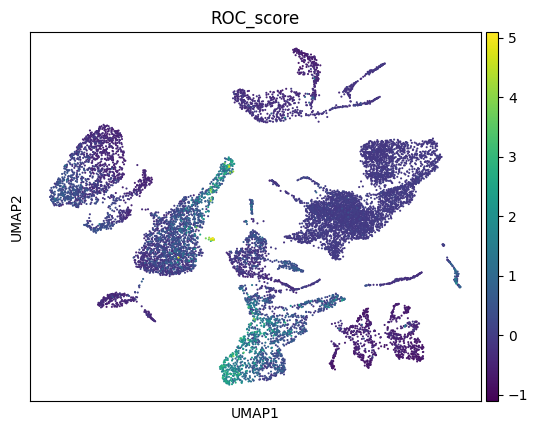

ROC cluster by score = 35
Consensus ROC markers (top 10): ['fn1.L', 'krt16.S', 'mmp11.L', 'loc101733581.L', 'fn1.S', 'hes2.L', 'mmp8.L', 'pthlh.S', 'ucma.S', 'Xelaev18038148m.g']


In [34]:
# genes visible in your matrix (filter to those that exist)
roc_markers_raw = ["fn1.L","fn1.S","krt16.S","mmp11.L","mmp8.L","loc101733581.L"]
present = [g for g in roc_markers_raw if g in adata.var_names]
print("ROC markers present:", present)

# module score and top cluster
sc.tl.score_genes(adata, gene_list=present, score_name="ROC_score", use_raw=False)

adata.obs["leiden"] = adata.obs["leiden"].astype(str)
mean_scores = (
    adata.obs.groupby("leiden")["ROC_score"]
         .mean()
         .sort_values(ascending=False)
)
print("Top clusters by ROC_score:\n", mean_scores.head(10))

# show UMAP of the score
sc.pl.umap(adata, color="ROC_score", cmap="viridis")

# pick the best-scoring cluster as ROC (should be '35')
roc_id = mean_scores.index[0]
print("ROC cluster by score =", roc_id)

# pull its top-k markers
TOP_K = 50
roc_w = df_wilcoxon.query("cluster == @roc_id").sort_values("rank").head(TOP_K)
roc_t = df_ttestov .query("cluster == @roc_id").sort_values("rank").head(TOP_K)

# consensus = intersection prioritized
W = roc_w[["gene","rank"]].rename(columns={"rank":"rank_w"})
T = roc_t[["gene","rank"]].rename(columns={"rank":"rank_t"})
U = W.merge(T, on="gene", how="outer")
U["rank_w"] = U["rank_w"].fillna(TOP_K+1)
U["rank_t"] = U["rank_t"].fillna(TOP_K+1)
U["avg_rank"] = U[["rank_w","rank_t"]].mean(axis=1)
roc_consensus = (
    U.query("rank_w <= @TOP_K & rank_t <= @TOP_K")
     .sort_values("avg_rank")
)

print("Consensus ROC markers (top 10):", roc_consensus["gene"].head(10).tolist())


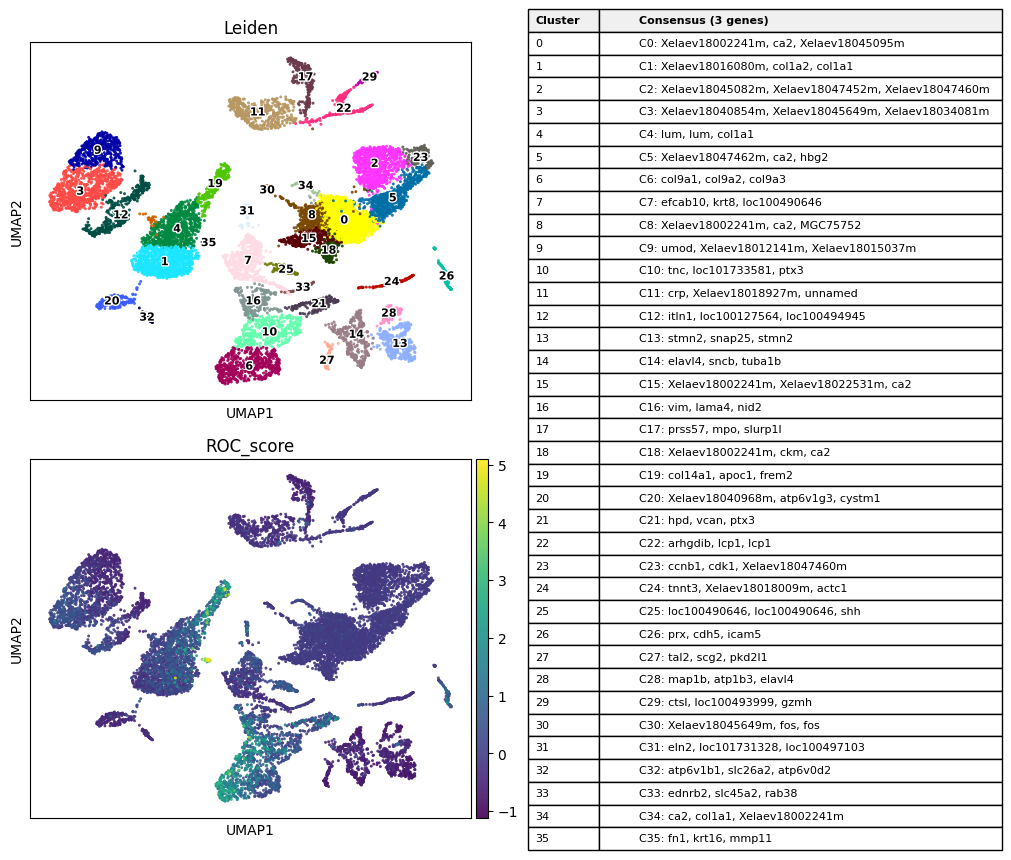

In [61]:
# combine umap, table of genes, and roc score into one plot
# using chatpt to help combine the plots
import matplotlib.gridspec as gridspec

label_df = (
    pd.Series(label_map, name="Consensus (3 genes)")
      .rename_axis("Cluster").to_frame().reset_index()
      .assign(Cluster=lambda d: d["Cluster"].astype(int))
      .sort_values("Cluster")
      .assign(Cluster=lambda d: d["Cluster"].astype(str))
)

adata.obs["leiden"] = adata.obs["leiden"].astype(str)

# Create a 2x2 GridSpec where the right column spans both rows (table)
fig = plt.figure(figsize=(10, 8.5), constrained_layout=True)
gs  = gridspec.GridSpec(nrows=2, ncols=2, figure=fig,
                        width_ratios=[1.4, 1.5], height_ratios=[1, 1])

ax_leiden   = fig.add_subplot(gs[0, 0])   # top-left
ax_rocscore = fig.add_subplot(gs[1, 0])   # bottom-left
ax_table    = fig.add_subplot(gs[:, 1])   # right column spans both rows

# --- Left/top: Leiden UMAP with on-data labels ---
sc.pl.umap(
    adata,
    color="leiden",
    legend_loc="on data",
    legend_fontsize=8,
    legend_fontoutline=2,
    size=18, alpha=0.9,
    ax=ax_leiden, show=False
)
ax_leiden.set_title("Leiden")
ax_leiden.set_aspect("auto")

# --- Left/bottom: ROC module score UMAP ---
sc.pl.umap(
    adata,
    color="ROC_score",
    cmap="viridis",
    colorbar_loc="right",
    size=18, alpha=0.9,
    ax=ax_rocscore, show=False
)
ax_rocscore.set_title("ROC_score")
ax_rocscore.set_aspect("auto")

# --- Right: compact table of consensus labels ---
ax_table.axis("off")
rows = label_df.values.tolist()
tbl = ax_table.table(
    cellText=rows,
    colLabels=list(label_df.columns),
    cellLoc="left", colLoc="left",
    loc="center",
    colWidths=[0.15, 0.85],
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.0, 1.15)
for (r, c), cell in tbl.get_celld().items():
    if r == 0:
        cell.set_facecolor("#f0f0f0")
        cell.set_text_props(weight="bold")

plt.show()

### Data Denoising

*   kNN smoothing
*   Iterative kNN smoothing



In [40]:
def mean_silhouette(D, lab_key, n_pcs=30):
  X = D.obsm["X_pca"][:, :n_pcs]
  y = D.obs[lab_key].astype(str).values
  n = X.shape[0]; DM = pairwise_euclidean(X)
  groups = {}
  for i,lab in enumerate(y): groups.setdefault(lab, []).append(i)
  groups = {k: np.asarray(v, int) for k, v in groups.items()}
  a = np.zeros(n); b = np.zeros(n)
  for lab, idx in groups.items():
      k = len(idx)
      a[idx] = 0.0 if k==1 else DM[np.ix_(idx, idx)].sum(axis=1)/(k-1)
  for i in range(n):
      means = [DM[i, idx].mean() for lab2, idx in groups.items() if lab2 != y[i]]
      b[i] = min(means) if means else 0.0
  s = np.zeros(n)
  m1 = (a<b) & (b>0); s[m1] = 1.0 - (a[m1]/b[m1])
  m2 = (a>b) & (a>0); s[m2] = (b[m2]/a[m2]) - 1.0
  return float(np.mean(s))

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

[KNN smoothing] mean silhouette vs baseline: 0.2825

[KNN smoothing] Overlap vs Baseline (Wilcoxon):
   cluster  overlap  A_topk  B_topk
0        0       42      50      50
1        1       33      50      50
2       10       25      50      50
3       11       23      50      50
4       12       36      50      50
5       13       24      50      50
6       14       22      50      50
7       15       41      50      50
8       16       34      50      50
9       17       30      50      50
10      18       42      50      50
11      19       31      50      50
12       2       39      50      50
13      20       39      50      50
14      21       34      50      50
15      22       38      50      50
16      23       37      50      50
17      24       37      50      50
18      25       33      50      50
19      26       28      50      50
20      27       20      50      50
21      28       17      50      50
22      29       34      50      50
23       3       26      50      50

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 


[Iterative KNN] mean silhouette vs baseline: 0.2825

[Iterative KNN] Overlap vs Baseline (Wilcoxon):
   cluster  overlap  A_topk  B_topk
0        0       40      50      50
1        1       25      50      50
2       10       18      50      50
3       11       20      50      50
4       12       34      50      50
5       13       13      50      50
6       14       18      50      50
7       15       27      50      50
8       16       20      50      50
9       17       28      50      50
10      18       30      50      50
11      19       29      50      50
12       2       26      50      50
13      20       38      50      50
14      21       31      50      50
15      22       29      50      50
16      23       29      50      50
17      24       36      50      50
18      25       30      50      50
19      26       22      50      50
20      27       15      50      50
21      28       12      50      50
22      29       30      50      50
23       3       23      50      5

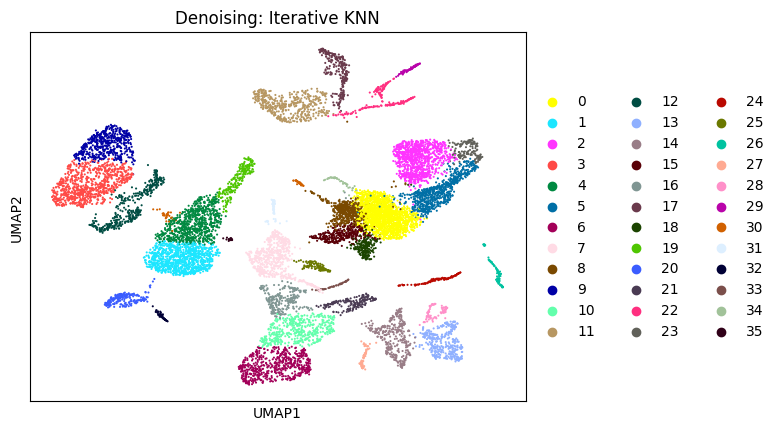

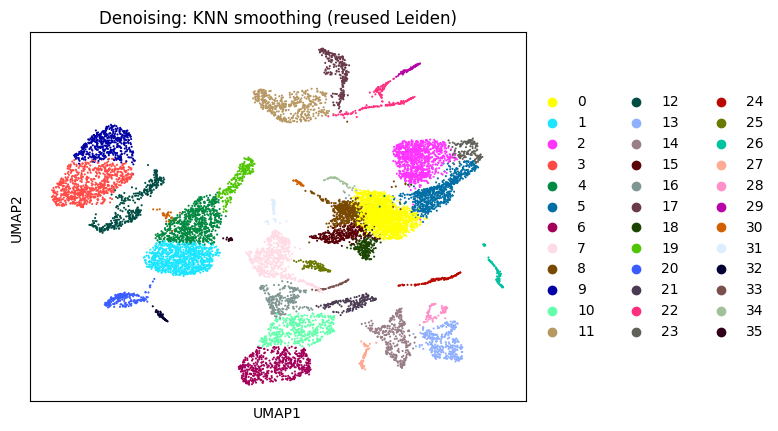

In [41]:
from scipy import sparse as sp

def knn_smooth(D):
  """"
  kNN smoothing of AnnData object's expression matrix.
  Uses existing neighbor graph stored at `D.obsp['connectivities']`
  """
    W = D.obsp.get("connectivities", None)
    if W is None:
        raise ValueError("No neighbor graph found in .obsp['connectivities']. Run sc.pp.neighbors first.")
    # row-normalize W
    rs = np.array(W.sum(axis=1)).ravel()
    rs[rs == 0] = 1.0
    Dnorm = sp.diags(1.0 / rs) @ W
    X = D.X.A if sp.issparse(D.X) else D.X
    Ms = Dnorm @ X
    # store smoothed matrix in a layer
    D.layers["Ms"] = sp.csr_matrix(Ms) if sp.issparse(D.X) else Ms

# kNN smoothing (single pass)
D_knn = adata.copy()

# build/reuse neighbors on PCA
if "connectivities" not in D_knn.obsp:
    sc.pp.neighbors(D_knn, n_neighbors=15, n_pcs=30)
knn_smooth(D_knn)
# use the smoothed expression as working matrix
D_knn.X = D_knn.layers["Ms"].astype(np.float32)

# evaluate
sil_knn = mean_silhouette(D_knn, "leiden", n_pcs=30)
knn_w, knn_t = _rank_markers(D_knn, group_key="leiden", prefix="knn")
knn_w_top = knn_w[knn_w["rank"] <= TOP_K]
knn_t_top = knn_t[knn_t["rank"] <= TOP_K]

print(f"[KNN smoothing] mean silhouette vs baseline: {sil_knn:.4f}")
print("\n[KNN smoothing] Overlap vs Baseline (Wilcoxon):")
print(_topk_overlap(df_wilcoxon_top, knn_w_top, k=TOP_K))
print("\n[KNN smoothing] Overlap vs Baseline (t-test_overestim_var):")
print(_topk_overlap(df_ttestov_top,  knn_t_top, k=TOP_K))

# Iterative kNN smoothing (two passes)
D_iknn = adata.copy()

# pass 1: neighbors -> smooth -> set X
if "connectivities" not in D_iknn.obsp:
    sc.pp.neighbors(D_iknn, n_neighbors=15, n_pcs=30)
knn_smooth(D_iknn)
D_iknn.X = D_iknn.layers["Ms"].astype(np.float32)

# pass 2: recompute neighbors on smoothed X -> smooth again -> set X
sc.pp.neighbors(D_iknn, n_neighbors=15, n_pcs=30)
knn_smooth(D_iknn)
D_iknn.X = D_iknn.layers["Ms"].astype(np.float32)

sil_iknn = mean_silhouette(D_iknn, "leiden", n_pcs=30)
iknn_w, iknn_t = _rank_markers(D_iknn, group_key="leiden", prefix="iknn")
iknn_w_top = iknn_w[iknn_w["rank"] <= TOP_K]
iknn_t_top = iknn_t[iknn_t["rank"] <= TOP_K]

print(f"\n[Iterative KNN] mean silhouette: {sil_iknn:.4f}")
print("\n[Iterative KNN] Overlap vs Baseline (Wilcoxon):")
print(_topk_overlap(df_wilcoxon_top, iknn_w_top, k=TOP_K))
print("\n[Iterative KNN] Overlap vs Baseline (t-test_overestim_var):")
print(_topk_overlap(df_ttestov_top,  iknn_t_top, k=TOP_K))

# UMAPs
sc.pl.umap(D_iknn, color="leiden", title="Denoising: Iterative KNN")
sc.pl.umap(D_knn, color="leiden", title="Denoising: KNN smoothing (reused Leiden)")

### Batch Integration

*   Harmony
*   BBKNN



In [42]:
!pip -q install harmonypy bbknn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [53]:
import bbknn

TIME_KEY = "DaysPostAmputation"
if TIME_KEY not in adata.obs:
    raise KeyError(f"'{TIME_KEY}' not found in adata.obs")

# make numerical to categorical D0, D1, ..., etc
adata.obs[TIME_KEY] = (
    adata.obs[TIME_KEY]
    .astype(int).astype(str)
    .radd("D")
    .astype("category"))

In [55]:
# Harmony
I_harmony = adata.copy()
sc.pp.scale(I_harmony, max_value=10)
sc.tl.pca(I_harmony, svd_solver="arpack")
sc.external.pp.harmony_integrate(I_harmony, key=TIME_KEY)
I_harmony.obs["leiden"] = adata.obs["leiden"].astype(str)
_Xpca_backup = I_harmony.obsm["X_pca"].copy()
I_harmony.obsm["X_pca"] = I_harmony.obsm["X_pca_harmony"]
sil_harmony_time = mean_silhouette(I_harmony, "leiden", n_pcs=30)
I_harmony.obsm["X_pca"] = _Xpca_backup

# markers
harm_w, harm_t = _rank_markers(I_harmony, group_key="leiden", prefix="harm_time")
harm_w_top = harm_w[harm_w["rank"] <= TOP_K].copy()
harm_t_top = harm_t[harm_t["rank"] <= TOP_K].copy()

print(f"[Harmony (time:{TIME_KEY})] mean silhouette: {sil_harmony_time:.4f}")
print("\n[Harmony (time)] Overlap vs Baseline (Wilcoxon):")
print(_topk_overlap(df_wilcoxon_top, harm_w_top, k=TOP_K))
print("\n[Harmony (time)] Overlap vs Baseline (t-test_overestim_var):")
print(_topk_overlap(df_ttestov_top,  harm_t_top,  k=TOP_K))

2025-10-07 18:17:29,245 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-10-07 18:17:37,841 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-10-07 18:17:37,953 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-10-07 18:17:46,917 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-10-07 18:17:56,294 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-10-07 18:18:10,029 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid valu

[Harmony (time:DaysPostAmputation)] mean silhouette: 0.2399

[Harmony (time)] Overlap vs Baseline (Wilcoxon):
   cluster  overlap  A_topk  B_topk
0        0       50      50      50
1        1       50      50      50
2       10       50      50      50
3       11       50      50      50
4       12       50      50      50
5       13       50      50      50
6       14       50      50      50
7       15       50      50      50
8       16       50      50      50
9       17       50      50      50
10      18       50      50      50
11      19       50      50      50
12       2       50      50      50
13      20       50      50      50
14      21       50      50      50
15      22       50      50      50
16      23       50      50      50
17      24       50      50      50
18      25       50      50      50
19      26       50      50      50
20      27       50      50      50
21      28       50      50      50
22      29       50      50      50
23       3       50      5

In [56]:
# BBKNN
I_bbknn = adata.copy()
sc.pp.scale(I_bbknn, max_value=10)
sc.tl.pca(I_bbknn, svd_solver="arpack")
sc.external.pp.bbknn(I_bbknn, batch_key=TIME_KEY)
I_bbknn.obs["leiden"] = adata.obs["leiden"].astype(str)
sil_bbknn_time = mean_silhouette(I_bbknn, "leiden", n_pcs=30)

# markers
bb_w, bb_t = _rank_markers(I_bbknn, group_key="leiden", prefix="bb_time")
bb_w_top = bb_w[bb_w["rank"] <= TOP_K].copy()
bb_t_top = bb_t[bb_t["rank"] <= TOP_K].copy()

print(f"\n[BBKNN (time:{TIME_KEY})] mean silhouette: {sil_bbknn_time:.4f}")
print("\n[BBKNN (time)] Overlap vs Baseline (Wilcoxon):")
print(_topk_overlap(df_wilcoxon_top, bb_w_top, k=TOP_K))
print("\n[BBKNN (time)] Overlap vs Baseline (t-test_overestim_var):")
print(_topk_overlap(df_ttestov_top,  bb_t_top,  k=TOP_K))

/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.12/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 


[BBKNN (time:DaysPostAmputation)] mean silhouette: 0.2764

[BBKNN (time)] Overlap vs Baseline (Wilcoxon):
   cluster  overlap  A_topk  B_topk
0        0       50      50      50
1        1       50      50      50
2       10       50      50      50
3       11       50      50      50
4       12       50      50      50
5       13       50      50      50
6       14       50      50      50
7       15       50      50      50
8       16       50      50      50
9       17       50      50      50
10      18       50      50      50
11      19       50      50      50
12       2       50      50      50
13      20       50      50      50
14      21       50      50      50
15      22       50      50      50
16      23       50      50      50
17      24       50      50      50
18      25       50      50      50
19      26       50      50      50
20      27       50      50      50
21      28       50      50      50
22      29       50      50      50
23       3       50      50  